<a href="https://colab.research.google.com/github/kashif/blog/blob/autoformer/exchange-rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install transformers datasets evaluate accelerate "gluonts[pro,torch]" ujson tqdm huggingface_hub

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/google/colab/_shell.py:99 in system                      │
│                                                                                                  │
│    96 │   if pip_warn:                                                                           │
│    97 │     kwargs.update({'also_return_output': True})                                          │
│    98 │                                                                                          │
│ ❱  99 │   output = _system_commands._system_compat(self, *args, **kwargs)  # pylint:disable=pr   │
│   100 │                                                                                          │
│   101 │   if pip_warn:                                                                           │
│   102 │     _pip.print_previous_import_warning(output)                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/google/colab/_system_commands.py:453 in _system_compat   │
│                                                                                                  │
│   450   # We set a higher depth than the IPython system command since a shell object             │
│   451   # is expected to call this function, thus adding one level of nesting to the             │
│   452   # stack.                                                                                 │
│ ❱ 453   result = _run_command(                                                                   │
│   454 │     shell.var_expand(cmd, depth=2), clear_streamed_output=False                          │
│   455   )                                                                                        │
│   456   shell.user_ns['_exit_code'] = result.returncode                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/google/colab/_system_commands.py:167 in _run_command     │
│                                                                                                  │
│   164   """Calls the shell command, forwarding input received on the stdin_socket."""            │
│   165   locale_encoding = locale.getpreferredencoding()                                          │
│   166   if locale_encoding != _ENCODING:                                                         │
│ ❱ 167 │   raise NotImplementedError(                                                             │
│   168 │   │   'A UTF-8 locale is required. Got {}'.format(locale_encoding)                       │
│   169 │   )                                                                                      │
│   170                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
from gluonts.dataset.repository.datasets import get_dataset

# traffic_dataset = get_dataset("traffic")
# electricity_dataset = get_dataset("electricity")
exchange_dataset = get_dataset("exchange_rate")

dataset = exchange_dataset

In [ ]:
train_dataset = dataset.train
test_dataset = dataset.test
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length

In [ ]:
# Transformations

from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [ ]:
# InstanceSplitter

from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [ ]:
# Dataloaders

from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
# time_features and lags

from gluonts.time_feature import time_features_from_frequency_str
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
time_features = time_features_from_frequency_str(freq)

In [ ]:
# Model & hyperparams

context_length = prediction_length*2
batch_size = 128
num_batches_per_epoch = 100
epochs = 50
scaling = "std"

encoder_layers=2
decoder_layers=2
d_model=16

from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length*2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # +1 for the age feature
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    # num_static_categorical_features=0,
    # it has 366 possible values:
    # cardinality=[len(train_dataset)],
    
    scaling=scaling,
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    # embedding_dimension=[2],
    encoder_layers=encoder_layers, 
    decoder_layers=decoder_layers,
    d_model=d_model,
)

model = AutoformerForPrediction(config)

In [ ]:
# train & test dataloaders

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    shuffle_buffer_length=1024,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [25]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = epochs
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(f"{loss.item():.3f}")

0.473
-1.774
-1.889
-2.498
-2.396
-2.684
-2.600
-2.956
-2.832
-2.769
-2.527
-2.707
1.113
-2.632
-3.015
-2.977
-2.623
-2.488
-2.758
-2.667
-3.215
-3.042
-3.145
-2.890
-2.828
-2.855
-2.971
-2.925
-3.309
-2.783
-3.181
-3.002
-2.953
-2.902
-0.093
-2.928
-2.965
-2.997
-3.169
-3.039
-2.999
-2.926
-3.154
-3.027
-3.355
-3.078
-2.799
-2.881
-2.989
-2.920


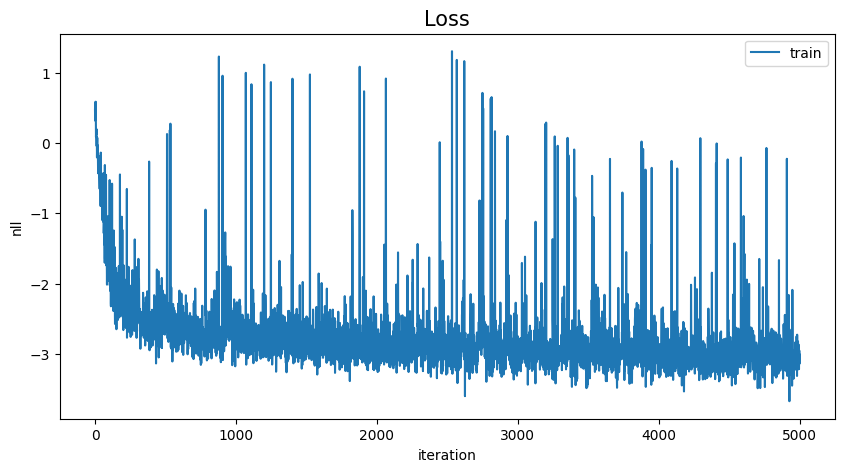

In [26]:
import matplotlib.pyplot as plt

# view training
x = range(len(loss_history))
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

In [27]:
from huggingface_hub import notebook_login
notebook_login()

In [28]:
model.push_to_hub(f"elisim/autoformer-exchange-rate-{epochs}-epochs")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/111k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/111k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/elisim/autoformer-exchange-rate-50-epochs/commit/c2dc290be8fd70a86246d33866037d238c6b0098', commit_message='Upload AutoformerForPrediction', commit_description='', oid='c2dc290be8fd70a86246d33866037d238c6b0098', pr_url=None, pr_revision=None, pr_num=None)